In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import ta
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau, StepLR
from torch.utils.data import DataLoader, random_split
import evaluation
import strategy

In [2]:
raw = yf.download(
    "SPY",
    start="1990-01-01",
    end="2021-01-01",
    auto_adjust = True,
    group_by="Ticker",
)

[*********************100%***********************]  1 of 1 completed


In [3]:
df = ta.utils.dropna(raw)
df = ta.add_all_ta_features(df, "Open", "High", "Low", "Close", "Volume", fillna=True)

/Users/qingweilan/.pyenv/versions/3.8.12/lib/python3.8/site-packages/ta/trend.py:768: RuntimeWarning: invalid value encountered in double_scalars
  dip[i] = 100 * (self._dip[i] / self._trs[i])
/Users/qingweilan/.pyenv/versions/3.8.12/lib/python3.8/site-packages/ta/trend.py:772: RuntimeWarning: invalid value encountered in double_scalars
  din[i] = 100 * (self._din[i] / self._trs[i])


In [4]:
df['feature_sma_diff'] = df['trend_sma_fast'] - df['trend_sma_slow']
df['feature_ema_diff'] = df['trend_ema_fast'] - df['trend_ema_slow']
df['feature_diff_bbl'] = df['Close'] - df['volatility_bbl']
df['feature_diff_bbh'] = df['volatility_bbh'] - df['Close']

In [6]:
cols = [
    'Open',
    'Close',
    'High',
    'Low',
    'trend_macd_diff',
    'feature_sma_diff',
    'feature_ema_diff',
    'feature_diff_bbl',
    'feature_diff_bbh',
    'momentum_roc',
    'trend_sma_fast',
    'trend_sma_slow',
    'trend_ema_fast',
    'trend_ema_slow',
    'momentum_rsi',
    'trend_cci',
]
len(cols)

16

In [7]:
data = df[cols]

In [8]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(-1,1))
data['price'] = scaler.fit_transform(data['Close'].values.reshape(-1,1))

data['Open'] = MinMaxScaler(feature_range=(-1,1)).fit_transform(data['Open'].values.reshape(-1,1))
data['High'] = MinMaxScaler(feature_range=(-1,1)).fit_transform(data['High'].values.reshape(-1,1))
data['Low'] = MinMaxScaler(feature_range=(-1,1)).fit_transform(data['Low'].values.reshape(-1,1))

price = data[cols+['price']]
price = price.drop(columns=['Close'])
price

/var/folders/cc/2hgv16qj2r95km6wqkh0r0z80000gn/T/ipykernel_60863/2018661324.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['price'] = scaler.fit_transform(data['Close'].values.reshape(-1,1))
/var/folders/cc/2hgv16qj2r95km6wqkh0r0z80000gn/T/ipykernel_60863/2018661324.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Open'] = MinMaxScaler(feature_range=(-1,1)).fit_transform(data['Open'].values.reshape(-1,1))
/var/folders/cc/2hgv16qj2r95km6wqkh0r0z80000gn/T/ipykernel_60863/2018661324.py:6: Se

,Open,High,Low,trend_macd_diff,feature_sma_diff,feature_ema_diff,feature_diff_bbl,feature_diff_bbh,momentum_roc,trend_sma_fast,trend_sma_slow,trend_ema_fast,trend_ema_slow,momentum_rsi,trend_cci,price
Date,,,,,,,,,,,,,,,,
1993-01-29,-0.998090,-0.998534,-0.996800,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,25.717381,25.717381,25.717381,25.717381,100.000000,0.000000,-0.998197
1993-02-01,-0.998090,-0.997591,-0.996053,0.011672,0.000000,0.014591,0.274355,0.091452,0.000000,25.808832,25.808832,25.745519,25.730929,100.000000,66.666667,-0.997136
1993-02-02,-0.997241,-0.997172,-0.995519,0.021852,0.000000,0.030234,0.300868,0.105758,0.000000,25.857609,25.857609,25.777772,25.747539,100.000000,78.128275,-0.996818
1993-02-03,-0.996605,-0.995602,-0.994666,0.044520,0.000000,0.064031,0.646007,0.088137,0.000000,25.950588,25.950588,25.847273,25.783241,100.000000,124.240668,-0.995226
1993-02-04,-0.994695,-0.994764,-0.994346,0.063221,0.000000,0.098538,0.763179,0.141243,0.000000,26.028330,26.028330,25.922969,25.824431,100.000000,102.027651,-0.994590
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-24,0.967083,0.946532,0.976203,-0.618906,2.871336,3.737616,7.602078,2.486016,0.108843,363.647202,360.775866,363.664803,359.927186,62.058532,68.414266,0.971972
2020-12-28,0.988109,0.966717,0.997112,-0.403917,2.776041,3.851626,10.428256,0.028198,1.882628,364.214742,361.438701,364.418623,360.566998,66.443729,165.078263,0.990179
2020-12-29,1.000000,0.974712,0.995726,-0.331661,2.715951,3.840967,8.665146,0.754419,1.721541,364.733551,362.017600,364.948298,361.107332,64.641665,162.751172,0.986101


In [9]:
def split_data(stock, lookback):
    data_raw = stock.to_numpy() # convert to numpy array
    data = []
    
    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - lookback): 
        data.append(data_raw[index: index + lookback])
    
    data = np.array(data);
    test_set_size = int(np.round(0.2*data.shape[0]));
    train_set_size = data.shape[0] - (test_set_size);
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1,:]
    
    return [x_train, y_train, x_test, y_test]

In [10]:
lookback = 20 # choose sequence length
x_train, y_train, x_test, y_test = split_data(price, lookback)
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ',y_train.shape)
print('x_test.shape = ',x_test.shape)
print('y_test.shape = ',y_test.shape)

x_train.shape =  (5610, 19, 16)
y_train.shape =  (5610, 16)
x_test.shape =  (1403, 19, 16)
y_test.shape =  (1403, 16)


In [11]:
x_train_tensor = torch.from_numpy(x_train).type(torch.Tensor)
x_test_tensor = torch.from_numpy(x_test).type(torch.Tensor)
y_train_lstm = torch.from_numpy(y_train).type(torch.Tensor)
y_test_lstm = torch.from_numpy(y_test).type(torch.Tensor)
y_train_gru = torch.from_numpy(y_train).type(torch.Tensor)
y_test_gru = torch.from_numpy(y_test).type(torch.Tensor)

In [12]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, dropout=0.2)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out

In [16]:
import time

input_dim = len(cols)
hidden_dim = 128
num_layers = 2
output_dim = 1

model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
criterion = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adam(model.parameters(), lr=0.1)
scheduler = StepLR(optimiser, 10, gamma=0.1, verbose=True)

num_epochs = 100

train_losses = np.zeros(num_epochs)
test_losses = np.zeros(num_epochs)

start_time = time.time()

for t in range(num_epochs):
    y_train_pred = model(x_train_tensor)
    y_test_pred = model(x_test_tensor)

    train_loss = criterion(y_train_pred, y_train_lstm)
    test_loss = criterion(y_test_pred, y_test_lstm)

    print(f"Epoch {t}: Train MSE: {train_loss.item()}, Test MSE: {test_loss.item()}")
    train_losses[t] = train_loss.item()
    test_losses[t] = test_loss.item()

    optimiser.zero_grad()
    train_loss.backward()
    optimiser.step()
    
    scheduler.step()

training_time = time.time()-start_time
print("Training time: {}".format(training_time))

Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 0: Train MSE: 3093.170654296875, Test MSE: 16702.064453125
Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 1: Train MSE: 2720.588623046875, Test MSE: 15625.7138671875
Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 2: Train MSE: 2558.2392578125, Test MSE: 15027.0859375
Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 3: Train MSE: 2448.00244140625, Test MSE: 14473.267578125
Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 4: Train MSE: 2393.5283203125, Test MSE: 13971.3701171875
Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 5: Train MSE: 2392.634521484375, Test MSE: 13571.1201171875
Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 6: Train MSE: 2424.040283203125, Test MSE: 13284.9267578125
Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 7: Train MSE: 2457.641357421875, Test MSE: 13115.2412109375
Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 8: Train MSE: 2471.0671386

Epoch 71: Train MSE: 2400.477783203125, Test MSE: 13453.2529296875
Adjusting learning rate of group 0 to 1.0000e-08.
Epoch 72: Train MSE: 2400.474609375, Test MSE: 13453.24609375
Adjusting learning rate of group 0 to 1.0000e-08.
Epoch 73: Train MSE: 2400.484375, Test MSE: 13453.2470703125
Adjusting learning rate of group 0 to 1.0000e-08.
Epoch 74: Train MSE: 2400.498291015625, Test MSE: 13453.244140625
Adjusting learning rate of group 0 to 1.0000e-08.
Epoch 75: Train MSE: 2400.49951171875, Test MSE: 13453.259765625
Adjusting learning rate of group 0 to 1.0000e-08.
Epoch 76: Train MSE: 2400.476318359375, Test MSE: 13453.25
Adjusting learning rate of group 0 to 1.0000e-08.
Epoch 77: Train MSE: 2400.49462890625, Test MSE: 13453.2529296875
Adjusting learning rate of group 0 to 1.0000e-08.
Epoch 78: Train MSE: 2400.497314453125, Test MSE: 13453.2568359375
Adjusting learning rate of group 0 to 1.0000e-08.
Epoch 79: Train MSE: 2400.473388671875, Test MSE: 13453.251953125
Adjusting learning ra

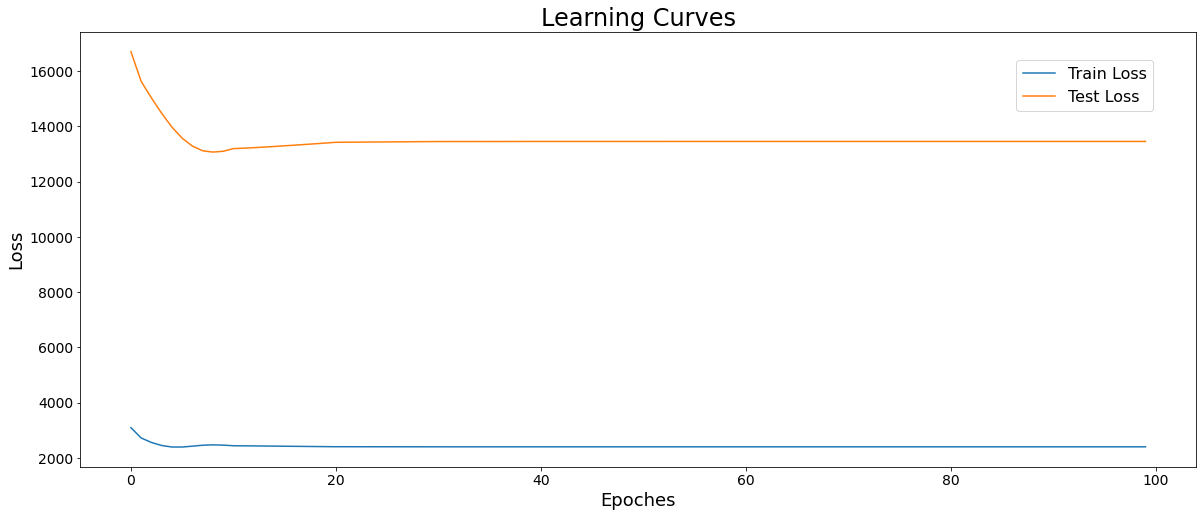

In [17]:
fig = plt.figure(figsize=(20,8))

plt.plot(train_losses, label="Train Loss")
plt.plot(test_losses, label="Test Loss")

plt.legend(loc='lower center', bbox_to_anchor=(0.9, 0.8), fontsize=16)

plt.title('Learning Curves', fontsize=24)
plt.xlabel('Epoches', fontsize=18)
plt.ylabel('Loss', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.show()

In [18]:
torch.save(model.state_dict(), 'models/lstm2')

# Load and Evaluate Model

In [20]:
model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
model.load_state_dict(torch.load('models/lstm2'))

<All keys matched successfully>

In [21]:
import math, time
from sklearn.metrics import mean_squared_error

lstm = []

# make predictions
y_train_pred = model(x_train_tensor)
y_test_pred = model(x_test_tensor)

# invert predictions
y_train_pred = scaler.inverse_transform(y_train_pred.detach().numpy())
y_train = scaler.inverse_transform(y_train_lstm.detach().numpy())
y_test_pred = scaler.inverse_transform(y_test_pred.detach().numpy())
y_test = scaler.inverse_transform(y_test_lstm.detach().numpy())

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train[:,0], y_train_pred[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[:,0], y_test_pred[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
lstm.append(trainScore)
lstm.append(testScore)
lstm.append(training_time)

Train Score: 5334.55 RMSE
Test Score: 5178.41 RMSE


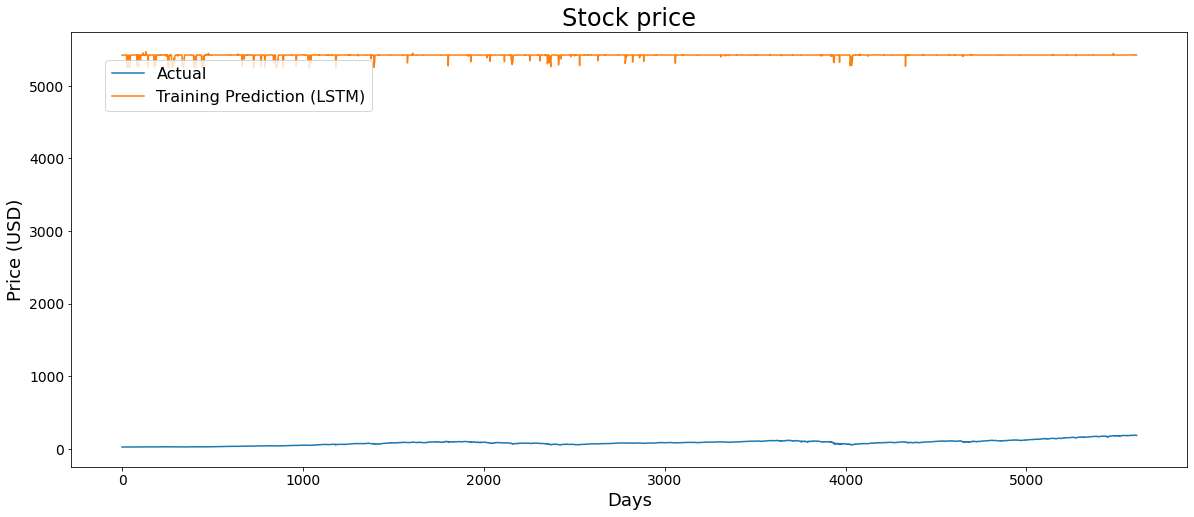

In [22]:
predict = pd.DataFrame(y_train_pred)
original = pd.DataFrame(scaler.inverse_transform(y_train_lstm.detach().numpy()))

plt.figure(figsize=(20,8))
plt.plot(original.index, original[0], label="Actual")
plt.plot(predict.index, predict[0], label="Training Prediction (LSTM)")

plt.legend(loc='lower center', bbox_to_anchor=(0.15, 0.8), fontsize=16)

plt.title('Stock price', fontsize=24)
plt.xlabel('Days', fontsize=18)
plt.ylabel('Price (USD)', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.show()

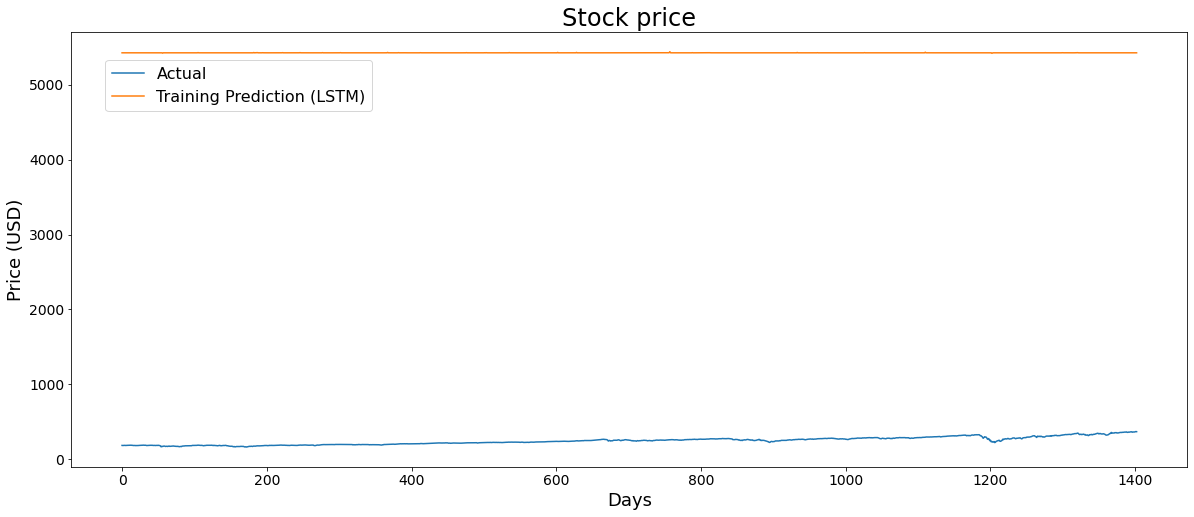

In [23]:
y_test = pd.DataFrame(y_test)
y_test_pred = pd.DataFrame(y_test_pred)

plt.figure(figsize=(20,8))
plt.plot(y_test.index, y_test[0], label="Actual")
plt.plot(y_test_pred.index, y_test_pred[0], label="Training Prediction (LSTM)")

plt.legend(loc='lower center', bbox_to_anchor=(0.15, 0.8), fontsize=16)

plt.title('Stock price', fontsize=24)
plt.xlabel('Days', fontsize=18)
plt.ylabel('Price (USD)', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.show()

In [206]:
actual_change = (y_test.shift(-1) - y_test) / y_test
pred_change = (y_test_pred.shift(-1) - y_test_pred) / y_test_pred
label_pred = pred_change > 0
label_actual = actual_change > 0
label = label_pred == label_actual
label.value_counts()

True     715
False    688
dtype: int64

In [205]:
changes = []
for idx, change in enumerate(pred_change[:-1].to_numpy().reshape(-1)):
    if change > 0:
        print(f"[{idx}] \t BUY: {change}")
    elif change < 0:
        print(f"[{idx}] \t SELL: {change}")
    changes.append(change)
pd.DataFrame(changes).describe()

[0] 	 SELL: -0.0017413387540727854
[1] 	 SELL: -0.0019502206705510616
[2] 	 SELL: -0.0010116216726601124
[3] 	 SELL: -7.92612336226739e-05
[4] 	 SELL: -0.00011059823009418324
[5] 	 SELL: -0.0005456891958601773
[6] 	 SELL: -0.00037793442606925964
[7] 	 SELL: -7.034187001409009e-05
[8] 	 BUY: 0.0008788029081188142
[9] 	 BUY: 0.0010778404539451003
[10] 	 BUY: 0.0014242123579606414
[11] 	 BUY: 0.0015305749839171767
[12] 	 BUY: 0.0009400203707627952
[13] 	 BUY: 0.0002569499774836004
[14] 	 SELL: -0.00017988390754908323
[15] 	 SELL: -0.0019086592365056276
[16] 	 SELL: -0.0027300873771309853
[17] 	 SELL: -0.0022797060664743185
[18] 	 SELL: -0.0018013390945270658
[19] 	 SELL: -0.001598787377588451
[20] 	 SELL: -0.0009421529830433428
[21] 	 SELL: -0.0017406006809324026
[22] 	 SELL: -0.002047809073701501
[23] 	 SELL: -0.0010562125826254487
[24] 	 BUY: 0.0005291610723361373
[25] 	 BUY: 0.0017210965743288398
[26] 	 BUY: 0.0021775150671601295
[27] 	 BUY: 0.0027633619029074907
[28] 	 BUY: 0.00297399

,0
count,1402.000000
mean,0.000298
std,0.002088
min,-0.015085
25%,-0.000365
50%,0.000594
75%,0.001310
max,0.007679


In [96]:
from sklearn.metrics import precision_score, recall_score, accuracy_score

In [97]:
accuracy_score(label_actual, label_pred)

0.5096222380612973

In [98]:
precision_score(label_actual, label_pred)

0.5464994775339603

In [99]:
recall_score(label_actual, label_pred)

0.6731016731016731

In [208]:
def mark(row):
    if row['change'] > 0:
        return 'B'
    elif row['change'] < 0:
        return 'S'
    else:
        return 'H'

lstmd = data[-1403:-1]
lstmd['change'] = pred_change[:-1].to_numpy().reshape(-1)
lstmd['action'] = lstmd.apply(lambda row: mark(row), axis=1)
lstmd

/var/folders/cc/2hgv16qj2r95km6wqkh0r0z80000gn/T/ipykernel_48490/1067080769.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lstmd['change'] = pred_change[:-1].to_numpy().reshape(-1)
/var/folders/cc/2hgv16qj2r95km6wqkh0r0z80000gn/T/ipykernel_48490/1067080769.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lstmd['action'] = lstmd.apply(lambda row: mark(row), axis=1)


,Open,High,Low,Close,Volume,price,change,action
Date,,,,,,,,
2015-06-09,184.456482,185.031672,183.783966,184.456482,105034700,-0.077574,-0.001741,S
2015-06-10,185.270580,187.075774,185.208644,186.668716,134551300,-0.064744,-0.001950,S
2015-06-11,187.137689,187.677476,186.889919,187.270432,73876400,-0.061254,-0.001012,S
2015-06-12,186.394449,187.137758,185.544943,185.836960,135382400,-0.069568,-0.000079,S
2015-06-15,184.624641,185.341404,183.872474,185.040543,124384200,-0.074187,-0.000111,S
...,...,...,...,...,...,...,...,...
2020-12-23,364.712299,366.039314,363.662570,364.009186,46201400,0.963759,0.000264,B
2020-12-24,364.514223,365.455032,363.890351,365.425323,26457900,0.971972,0.000159,B
2020-12-28,368.138779,368.980551,367.475286,368.564636,39000400,0.990179,0.000105,B


In [209]:
lstm_perf = evaluation.eval(lstmd)

Performance: 81.4%


In [210]:
macd_perf = evaluation.eval(strategy.macd(data))

/Users/qingweilan/.pyenv/versions/3.8.12/lib/python3.8/site-packages/ta/trend.py:768: RuntimeWarning: invalid value encountered in double_scalars
  dip[i] = 100 * (self._dip[i] / self._trs[i])
/Users/qingweilan/.pyenv/versions/3.8.12/lib/python3.8/site-packages/ta/trend.py:772: RuntimeWarning: invalid value encountered in double_scalars
  din[i] = 100 * (self._din[i] / self._trs[i])


Performance: 176.58%


In [211]:
bh_perf = evaluation.eval(strategy.bh(data))

Performance: 98.84%


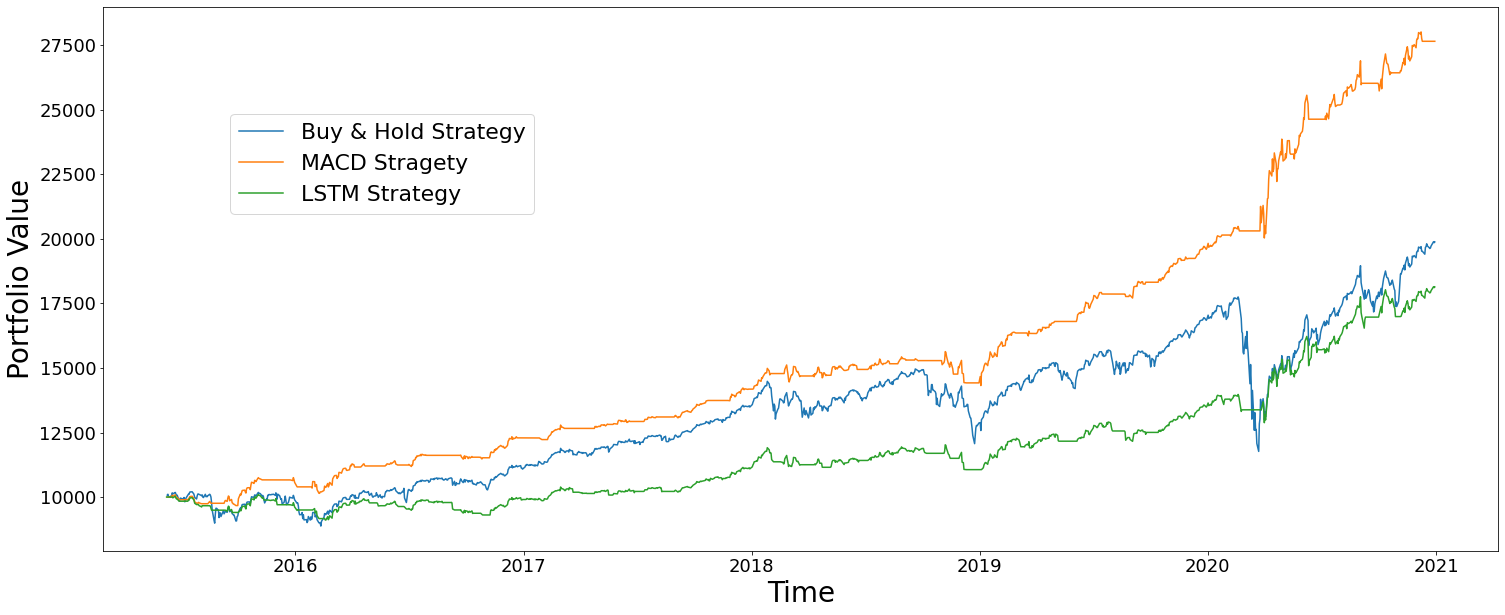

In [212]:
plt.figure(figsize=(25,10))

plt.plot(bh_perf['value'], label='Buy & Hold Strategy')
plt.plot(macd_perf['value'], label='MACD Stragety')
plt.plot(lstm_perf['value'], label='LSTM Strategy')

plt.legend(loc='lower center', bbox_to_anchor=(0.2, 0.6), fontsize=22)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel('Time', fontsize=28)
plt.ylabel('Portfolio Value', fontsize=28)

plt.show()

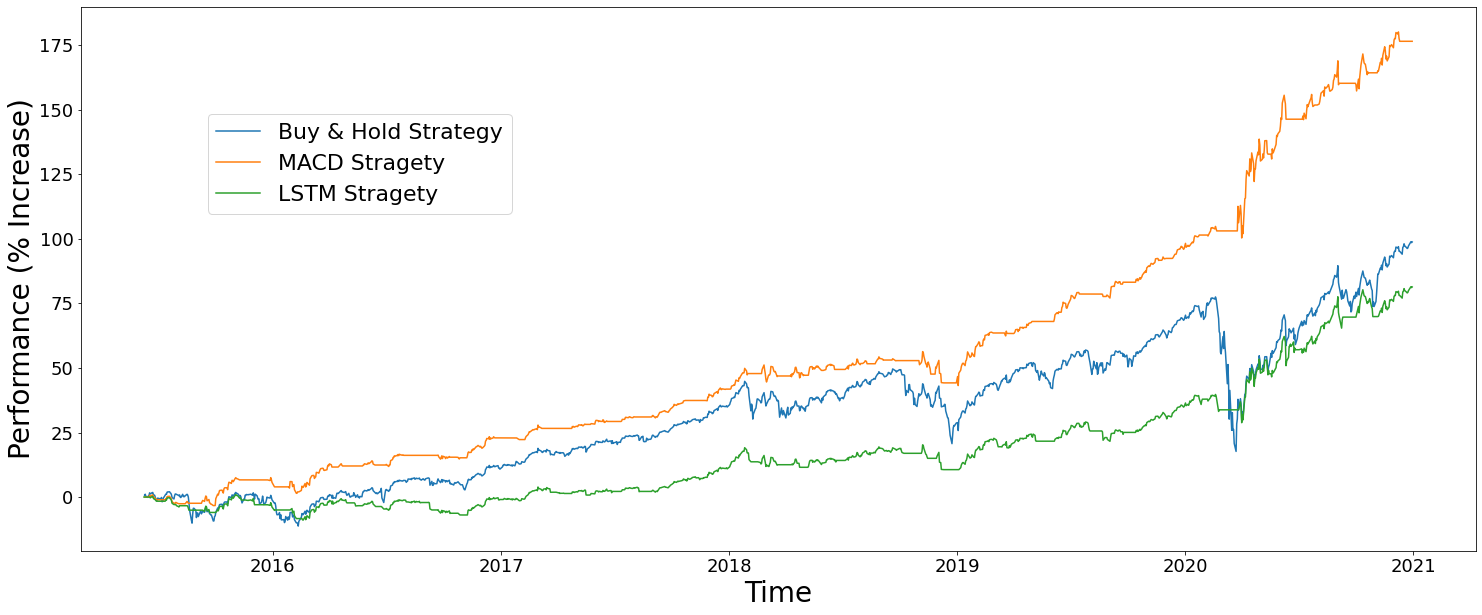

In [213]:
plt.figure(figsize=(25,10))

plt.plot(bh_perf['percentage'], label='Buy & Hold Strategy')
plt.plot(macd_perf['percentage'], label='MACD Stragety')
plt.plot(lstm_perf['percentage'], label='LSTM Stragety')

plt.legend(loc='lower center', bbox_to_anchor=(0.2, 0.6), fontsize=22)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel('Time', fontsize=28)
plt.ylabel('Performance (% Increase)', fontsize=28)

plt.show()